In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import networkx as nx
from tqdm import tqdm
import dateparser

In [44]:
!head data/climbers.csv

ClimbID,Ascent Date,Status,Climber Name,Climber URL,ClimberID
b0,5th Sep 2006,Boulder | worked,James Pearson,https://climbing-history.org/climber/153/james-pearson,6e9881ed7d25f55a2ce1d1c8ea00ca8c
b0,May 2009,Boulder | worked,Dave Nodden,https://climbing-history.org/climber/302/dave-nodden,754e3f412cd9f5c4aa15ec4b0f96abfd
b0,4th May 2009,Boulder | worked,Ignacio Sánchez González,https://climbing-history.org/climber/615/ignacio-sánchez-gonzález,2b4bba2c5647b04a00c7bdf3a17d96f8
b0,8th May 2010,Boulder | worked,Rupert Davies,https://climbing-history.org/climber/214/rupert-davies,a89d1410e41effd46116bdb5273bd717
b0,11th Sep 2010,Boulder | worked,Dawid Skoczylas,https://climbing-history.org/climber/250/dawid-skoczylas,fcfa53fbf39070ec2bd310047aeb2385
b0,19th Sep 2010,Boulder | worked,Mike Adams,https://climbing-history.org/climber/247/mike-adams,2ee20f6f7a9195224c63060afb390e4e
b0,23rd Oct 2010,Boulder | worked,Tim Palmer,https://climbing-history.org/climber/163/tim-palmer,25a47289d23be0309

In [50]:
kwargs = {
    'climbers_fpath': 'data/climbers.csv',
    'boulder_problems': 'data/boulder_problems.csv',
    'sport_routes': 'data/sport_routes.csv',
    'trad_climbs': 'data/trad_climbs.csv'
}


def parse_date(date):
    # if the date is not nan, parse it with dateparser else return None
    if pd.isna(date):
        return 'Unknown'
    else:
        return str(dateparser.parse(date))

def create_graphs(climbers_fpath, sport_routes, boulder_problems,trad_climbs):
    
    climbers = pd.read_csv(climbers_fpath).sort_values(['ClimberID','ClimbID'])
    boulder_problems = pd.read_csv(boulder_problems)
    sport_routes = pd.read_csv(sport_routes)
    trad_climbs = pd.read_csv(trad_climbs)
    

    # Create a graph of climbers
    total_graph = nx.Graph()
    boulder_graph = nx.Graph()
    sport_graph = nx.Graph()
    trad_graph = nx.Graph()

    typemap = {'b':'boulder', 's':'sport', 't':'trad'}

    id_map = {'b':boulder_problems, 's':sport_routes, 't':trad_climbs}
    id2_graph = {'b':boulder_graph, 's':sport_graph, 't':trad_graph}

    for i, climber in tqdm(climbers.iterrows()):

        climber_att = {'Name':climber['Climber Name']}
        # rename climbername to Name

        total_graph.add_node(climber['ClimberID'],**climber_att)
        id_prefix = climber['ClimbID'][0]


        id2_graph[id_prefix].add_node(climber['ClimberID'],**climber_att)
        

        # Get node
        climb_id = int(climber['ClimbID'][1:])
        climb_node = id_map[id_prefix].iloc[climb_id]

        climb_type = typemap[id_prefix]
        # Add the climb node to the climb specific graph and the total graph
        # add it with the attributes of the climnb ['Name', 'Grade', 'URL'] and type (in the case of the total graph)

        spec_att = climb_node[['Name', 'Grade', 'URL']].to_dict()
        spec_att['Grade'] = spec_att['Grade'].replace('(approx)', '').strip()
        id2_graph[id_prefix].add_node(climb_id, **spec_att)

        total_att =climb_node[['Name', 'Grade', 'URL']].to_dict()
        total_att['type'] = climb_type
        
        total_graph.add_node(climber['ClimbID'], **total_att)

        # add an edge between the climber and the climb in both the total graph and the specific graph
        # on the edge add the attribute 'Ascent Date' and 'Status' to the edge
        total_graph.add_edge(climber['ClimberID'], climber['ClimbID'], **{'Ascent Date':parse_date(climber['Ascent Date']), 'Status':climber['Status']})
        id2_graph[id_prefix].add_edge(climber['ClimberID'], climb_id, **{'Ascent Date':parse_date(climber['Ascent Date']), 'Status':climber['Status']})

        
        
    # print the number of edges and nodes in all graphs
    print('Total Graph: ', total_graph.number_of_nodes(), total_graph.number_of_edges())
    print('Boulder Graph: ', boulder_graph.number_of_nodes(), boulder_graph.number_of_edges())
    print('Sport Graph: ', sport_graph.number_of_nodes(), sport_graph.number_of_edges())
    print('Trad Graph: ', trad_graph.number_of_nodes(), trad_graph.number_of_edges())

    # save all graphs as gexf to ./graphs/
    nx.write_gexf(total_graph, 'graphs/total_graph.gexf')
    nx.write_gexf(boulder_graph, 'graphs/boulder_graph.gexf')
    nx.write_gexf(sport_graph, 'graphs/sport_graph.gexf')
    nx.write_gexf(trad_graph, 'graphs/trad_graph.gexf')
    
    
    





        

In [51]:
create_graphs(**kwargs)

9795it [01:32, 106.42it/s]


Total Graph:  5352 9757
Boulder Graph:  2269 4305
Sport Graph:  1956 3119
Trad Graph:  1683 2333


In [52]:
boulders = pd.read_csv('data/sport_routes.csv')
boulders['Grade'].value_counts()

Grade
8c              155
9a              155
8c+             139
8b              135
8a              125
8b+             116
9a+             112
8a+              76
9b               69
7c+              33
7c               22
9b+              11
7b+              11
7b                6
9c (approx)       4
7a                3
9c                3
7a+               3
6c+               2
9a+ (approx)      1
6a                1
6b+               1
6c                1
Name: count, dtype: int64

In [6]:
# read in all graphs
total_graph = nx.read_gexf('graphs/total_graph.gexf')
boulder_graph = nx.read_gexf('graphs/boulder_graph.gexf')
sport_graph = nx.read_gexf('graphs/sport_graph.gexf')
trad_graph = nx.read_gexf('graphs/trad_graph.gexf')

In [64]:
# Calculate the max degree of each graph
total_max_degree = max(dict(total_graph.degree()).values())
boulder_max_degree = max(dict(boulder_graph.degree()).values())
sport_max_degree = max(dict(sport_graph.degree()).values())
trad_max_degree = max(dict(trad_graph.degree()).values())

# print the nodes with the max degree for each graph (with attributes)
total_max_node = dict(total_graph.degree())
boulder_max_node = dict(boulder_graph.degree())
sport_max_node = dict(sport_graph.degree())
trad_max_node = dict(trad_graph.degree())


# get the node id from _max_node dict that has the corresponding max degree
total_max_node_id = max(total_max_node, key=total_max_node.get)
boulder_max_node_id = max(boulder_max_node, key=boulder_max_node.get)
sport_max_node_id = max(sport_max_node, key=sport_max_node.get)
trad_max_node_id = max(trad_max_node, key=trad_max_node.get)

# Then get the attributes of that node from the graph with attributesand print them
total_max_node = total_graph.nodes(data=True)[total_max_node_id]
boulder_max_node = boulder_graph.nodes(data=True)[boulder_max_node_id]
sport_max_node = sport_graph.nodes(data=True)[sport_max_node_id]
trad_max_node = trad_graph.nodes(data=True)[trad_max_node_id]


print('Total Graph Max Node: ', total_max_node)
print('Boulder Graph Max Node: ', boulder_max_node)
print('Sport Graph Max Node: ', sport_max_node)
print('Trad Graph Max Node: ', trad_max_node)




Total Graph Max Node:  {'Name': 'Adam Ondra', 'label': '90afcb46a6166832f30634fe93dbd6b5'}
Boulder Graph Max Node:  {'Name': 'Daniel Woods', 'label': '7b616feca693e96a07814bd5f810c868'}
Sport Graph Max Node:  {'Name': 'Adam Ondra', 'label': '90afcb46a6166832f30634fe93dbd6b5'}
Trad Graph Max Node:  {'Name': 'Dave MacLeod', 'label': '0ede587fe4b0244b1b8dd26947f1acbf'}


In [65]:
# Repeat the process for betweenness centrality
total_bc = nx.betweenness_centrality(total_graph)
boulder_bc = nx.betweenness_centrality(boulder_graph)
sport_bc = nx.betweenness_centrality(sport_graph)
trad_bc = nx.betweenness_centrality(trad_graph)

total_max_bc = max(total_bc, key=total_bc.get)
boulder_max_bc = max(boulder_bc, key=boulder_bc.get)
sport_max_bc = max(sport_bc, key=sport_bc.get)
trad_max_bc = max(trad_bc, key=trad_bc.get)

total_max_bc_node = total_graph.nodes(data=True)[total_max_bc]
boulder_max_bc_node = boulder_graph.nodes(data=True)[boulder_max_bc]
sport_max_bc_node = sport_graph.nodes(data=True)[sport_max_bc]
trad_max_bc_node = trad_graph.nodes(data=True)[trad_max_bc]


print('Total Graph Max BC Node: ', total_max_bc_node)
print('Boulder Graph Max BC Node: ', boulder_max_bc_node)
print('Sport Graph Max BC Node: ', sport_max_bc_node)
print('Trad Graph Max BC Node: ', trad_max_bc_node)



Total Graph Max BC Node:  {'Name': 'Adam Ondra', 'label': '90afcb46a6166832f30634fe93dbd6b5'}
Boulder Graph Max BC Node:  {'Name': 'Jimmy Webb', 'label': 'c84deabfb553b06e7a510e834fb75355'}
Sport Graph Max BC Node:  {'Name': 'Adam Ondra', 'label': '90afcb46a6166832f30634fe93dbd6b5'}
Trad Graph Max BC Node:  {'Name': 'Ron Fawcett', 'label': 'd7b6adfeaed4d5169aab4cdb8d25091c'}


{'label': '90afcb46a6166832f30634fe93dbd6b5'}

In [1]:
import pandas as pd

climbs = pd.read_csv('data/climbers.csv')
climbs.head()

,ClimbID,Ascent Date,Status,Climber Name,Climber URL,ClimberID
0,b0,5th Sep 2006,Boulder | worked,James Pearson,https://climbing-history.org/climber/153/james...,6e9881ed7d25f55a2ce1d1c8ea00ca8c
1,b0,May 2009,Boulder | worked,Dave Nodden,https://climbing-history.org/climber/302/dave-...,754e3f412cd9f5c4aa15ec4b0f96abfd
2,b0,4th May 2009,Boulder | worked,Ignacio Sánchez González,https://climbing-history.org/climber/615/ignac...,2b4bba2c5647b04a00c7bdf3a17d96f8
3,b0,8th May 2010,Boulder | worked,Rupert Davies,https://climbing-history.org/climber/214/ruper...,a89d1410e41effd46116bdb5273bd717
4,b0,11th Sep 2010,Boulder | worked,Dawid Skoczylas,https://climbing-history.org/climber/250/dawid...,fcfa53fbf39070ec2bd310047aeb2385


In [4]:

# parse the dates, but in case the value is nan, return nan
climbs['Parsed Ascent Date'] = climbs['Ascent Date'].apply(lambda x: dateparser.parse(x) if pd.notnull(x) else x)
climbs

,ClimbID,Ascent Date,Status,Climber Name,Climber URL,ClimberID,Parsed Ascent Date
0,b0,5th Sep 2006,Boulder | worked,James Pearson,https://climbing-history.org/climber/153/james...,6e9881ed7d25f55a2ce1d1c8ea00ca8c,2006-09-05 00:00:00
1,b0,May 2009,Boulder | worked,Dave Nodden,https://climbing-history.org/climber/302/dave-...,754e3f412cd9f5c4aa15ec4b0f96abfd,2009-05-10 00:00:00
2,b0,4th May 2009,Boulder | worked,Ignacio Sánchez González,https://climbing-history.org/climber/615/ignac...,2b4bba2c5647b04a00c7bdf3a17d96f8,2009-05-04 00:00:00
3,b0,8th May 2010,Boulder | worked,Rupert Davies,https://climbing-history.org/climber/214/ruper...,a89d1410e41effd46116bdb5273bd717,2010-05-08 00:00:00
4,b0,11th Sep 2010,Boulder | worked,Dawid Skoczylas,https://climbing-history.org/climber/250/dawid...,fcfa53fbf39070ec2bd310047aeb2385,2010-09-11 00:00:00
...,...,...,...,...,...,...,...
9790,s1154,17th Apr 2008,Lead | onsight,Chris Savage,https://climbing-history.org/climber/164/chris...,2f79142c651ad60bcaa7567d6c92cfd4,2008-04-17 00:00:00
9791,s1155,5th May 2024,Lead | flash,Lucy Mitchell,https://climbing-history.org/climber/407/lucy-...,23d67e7a105478e48f8b823c3161ec87,2024-05-05 00:00:00
9792,s1156,1996,Lead | onsight,Garth Miller,https://climbing-history.org/climber/1505/gart...,9d422ed200c3a141426c37e774855212,1996-10-10 00:00:00
9793,s1157,20th Nov 2022,Lead | worked,Adam Ondra,https://climbing-history.org/climber/467/adam-...,90afcb46a6166832f30634fe93dbd6b5,2022-11-20 00:00:00


In [7]:
# get the year of the ascent date for all edges in the boulder graph, and build a subgraph for each year. ignore edges that are unknown
# get the unique years
years = set()

for u,v,d in boulder_graph.edges(data=True):
    if d['Ascent Date'] != 'Unknown':
        year = d['Ascent Date'][:4]
        years.add((year))


# create a subgraph for each year
boulder_subgraphs = {}

subgraphs = []

allowed_years = ['2014','2015', '2016', '2017', '2018', '2019', '2020', '2021', '2022', '2023', '2024', '2025']
for year in tqdm(years):
    boulder_subgraphs[year] = boulder_graph.edge_subgraph([(u,v) for u,v,d in boulder_graph.edges(data=True) if d['Ascent Date'][:4] == year])

    if year in allowed_years:
        subgraphs += [(u,v) for u,v,d in boulder_graph.edges(data=True) if d['Ascent Date'][:4] == year]


massive_subgraph = boulder_graph.edge_subgraph(subgraphs) 

  0%|          | 0/57 [00:00<?, ?it/s]

100%|██████████| 57/57 [00:01<00:00, 54.60it/s]


In [8]:
boulder_subgraphs_sorted = [(year,boulder_subgraphs[year]) for year in sorted(boulder_subgraphs)]
# print the number of nodes and edges in each
for year, graph in boulder_subgraphs_sorted:
    print(year,'number of nodes:',graph.number_of_nodes(),'number of edges:',graph.number_of_edges())

1914 number of nodes: 2 number of edges: 1
1934 number of nodes: 2 number of edges: 1
1946 number of nodes: 2 number of edges: 1
1950 number of nodes: 3 number of edges: 2
1953 number of nodes: 2 number of edges: 1
1959 number of nodes: 2 number of edges: 1
1966 number of nodes: 2 number of edges: 1
1971 number of nodes: 2 number of edges: 1
1975 number of nodes: 3 number of edges: 2
1976 number of nodes: 2 number of edges: 1
1977 number of nodes: 2 number of edges: 1
1978 number of nodes: 3 number of edges: 2
1980 number of nodes: 2 number of edges: 1
1982 number of nodes: 4 number of edges: 2
1983 number of nodes: 14 number of edges: 13
1984 number of nodes: 11 number of edges: 6
1985 number of nodes: 6 number of edges: 4
1986 number of nodes: 4 number of edges: 2
1987 number of nodes: 6 number of edges: 3
1988 number of nodes: 4 number of edges: 2
1989 number of nodes: 7 number of edges: 4
1990 number of nodes: 2 number of edges: 1
1991 number of nodes: 4 number of edges: 3
1992 num

In [56]:
# for each year, get all the nodes with the highest "Grade" attribute, if the nodes have it
from collections import defaultdict
grades_year = defaultdict(dict)
year_grades_names = defaultdict(dict)




for year,graph in boulder_subgraphs.items():
    grades_year[year] = defaultdict(list)
    year_grades_names[year] = defaultdict(list)
    for node,data in graph.nodes(data=True):
        if 'Grade' in data.keys():
            grades_year[year][data['Grade']].append(node)
            year_grades_names[year][data['Grade']].append(data['Name'])

for year in sorted(years):
    grades = grades_year[year]
    sorted_grades = sorted(list(set(grades.keys())))
    print(year,"top 3:",sorted_grades[-3:])
    print("Hardes boulders:",[year_grades_names[year][grade] for grade in sorted_grades[-1:]])

1914 top 3: ['3']
Hardes boulders: [['La Prestat']]
1934 top 3: ['5+']
Hardes boulders: [["L'Angle Allain"]]
1946 top 3: ['6A']
Hardes boulders: [['La Marie-Rose']]
1950 top 3: ['6B', '6C']
Hardes boulders: [['Le Carre d’As']]
1953 top 3: ['7A']
Hardes boulders: [['La Joker']]
1959 top 3: ['7C']
Hardes boulders: [['Red Cross Overhang']]
1966 top 3: ['7A']
Hardes boulders: [['Barley Mow']]
1971 top 3: ['6A']
Hardes boulders: [['Banana Finger']]
1975 top 3: ['8A', '8A+']
Hardes boulders: [['Trice']]
1976 top 3: ['6C']
Hardes boulders: [['Not to be Taken Away']]
1977 top 3: ['6C']
Hardes boulders: [["Monty Python's Flying Circus"]]
1978 top 3: ['7B']
Hardes boulders: [['Midnight Lightning']]
1980 top 3: ['7C+']
Hardes boulders: [['Walk on By']]
1982 top 3: ['7A+', '7B+']
Hardes boulders: [['Le Mur des Lamentations']]
1983 top 3: ['7B+', '7C', '7C+']
Hardes boulders: [['Le Surplomb de la Mée (Pre-Break)']]
1984 top 3: ['7C', '7C+', '8A']
Hardes boulders: [["C'Était Demain"]]
1985 top 3: ['

100%|██████████| 1/1 [00:00<00:00, 5322.72it/s]


sorting
plotting


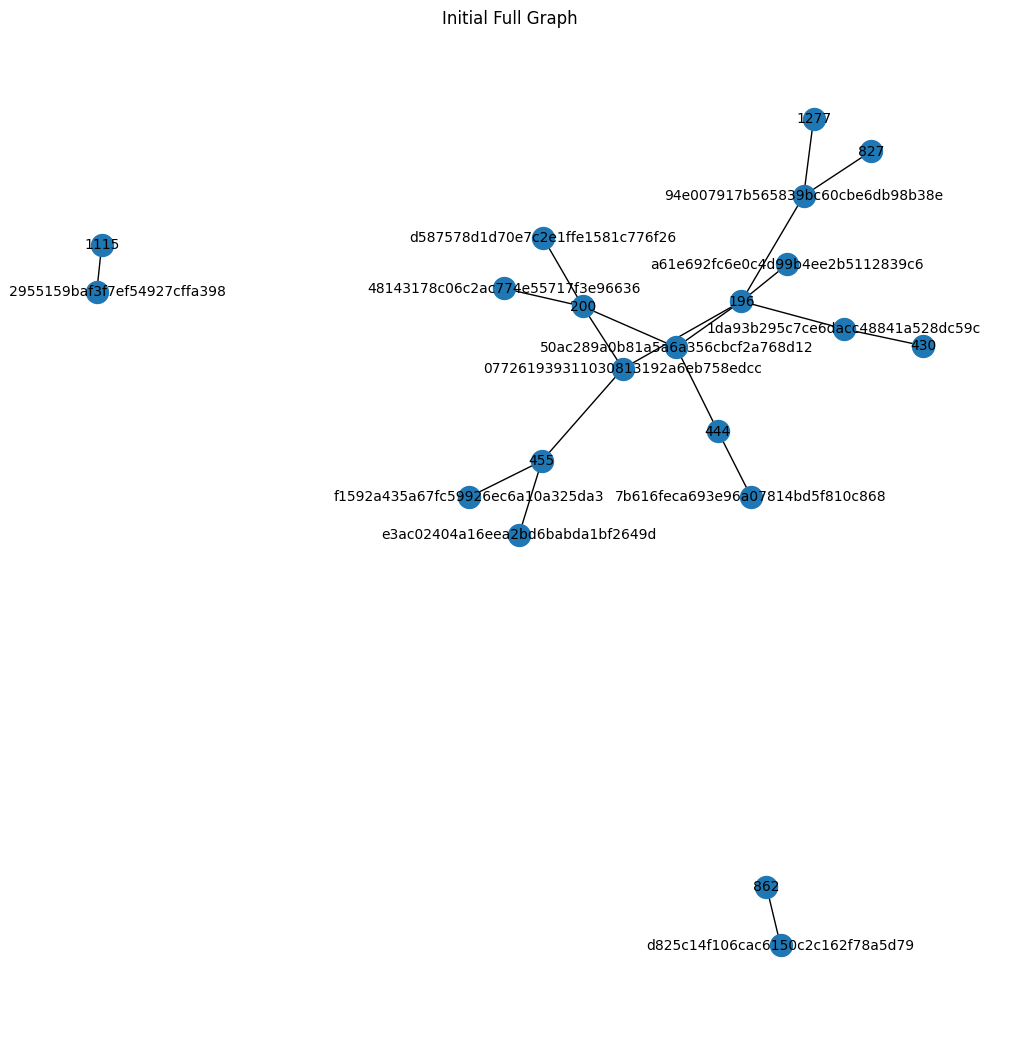

removing


0it [00:00, ?it/s]/var/folders/bf/0wxq49ds7wxdfh6q2mcfm3nm0000gn/T/ipykernel_1056/1752324860.py:88: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  images.insert(0,imageio.imread(f"temp/temp_plot_{i}.png"))
12it [00:03,  3.14it/s]


In [12]:
def get_top_n_boulders(graph,n):
    grades = defaultdict(list)
    for node,data in graph.nodes(data=True):
        if 'Grade' in data.keys():
            grades[data['Grade']].append(node)
    sorted_grades = sorted(list(set(grades.keys())))
    return [grades[grade] for grade in sorted_grades[-n:]]

def plot_graph(subgraphs,year,n=3):

    # Merge the latest 10 years into one big graph
    


    climb_nodes = get_top_n_boulders(graph=subgraphs[year],n=n)

    # get all nodes from climb_nodes and their neighbors from the graph and create a subgraph
    subgraph = nx.Graph()
    new_nodes = []
    for nodes in tqdm(climb_nodes):
        for node in nodes:
            new_nodes.append(node)
            for neighbor in subgraphs[year].neighbors(node):
                new_nodes.append(neighbor)

    subgraph = nx.subgraph(subgraphs[year],new_nodes)

    # replace the 'Ascent Date' attribute with the month and the year extracted from the string date
    for u,v,d in subgraph.edges(data=True):
        d['Ascent Date'] = d['Ascent Date'][:7]


    plot_graph_gif(subgraph,f'graphs/boulder_{year}.gif')


import networkx as nx
import matplotlib.pyplot as plt
import imageio
from datetime import datetime
import os
from collections import defaultdict

def get_sorted_edges_by_ascent_date(graph):
    """Returns edges sorted by 'Ascent Date'."""
    # Return the edges as a list of lists where each list contains all edges with the same 'Ascent Date'
    edges_by_date = {}
    for u, v, d in graph.edges(data=True):
        date = d['Ascent Date']
        if date not in edges_by_date:
            edges_by_date[date] = []
        edges_by_date[date].append((u, v))

    # Sort the edges by 'Ascent Date'
    sorted_edges = sorted(edges_by_date.items(), key=lambda x: datetime.strptime(x[0], '%Y-%m'), reverse=True)


    return sorted_edges

    
def remove_edges_and_plot(graph, sorted_edges, node_positions, filename):
    """Iteratively removes edges by most recent and plots the graph."""
    images = []
    current_graph = graph.copy()


    for i,cur_edges in tqdm(enumerate(sorted_edges)):
        
        
        
        plt.figure(figsize=(10, 10))
        # Use the attribute Name in the plot 
        
        labels = {}
        for node, data in current_graph.nodes(data=True):
            if 'Name' in data:
                labels[node] = data['Name']
            else:
                labels[node] = str(node)

        # Draw the graph with node labels

        betweenness = nx.betweenness_centrality(current_graph)
        node_size = [1000 * betweenness[node] + 100 for node in current_graph.nodes()]

        nx.draw(current_graph, pos=node_positions, labels=labels, with_labels=True, node_size=node_size, font_size=10)
        plt.title(cur_edges[0])
        plt.savefig(f"temp/temp_plot_{i}.png")
        images.insert(0,imageio.imread(f"temp/temp_plot_{i}.png"))
        plt.close()
        # delete the temp plot
        #os.remove(f"temp/temp_plot_{i}.png")

        # remove edges from the current graph
        for e in cur_edges[1]:
            try:
                current_graph.remove_edges_from([e])
            except:
                pass
        
        # Remove isolates (nodes with no connections)
        isolates = list(nx.isolates(current_graph))
        current_graph.remove_nodes_from(isolates)

        # Break if no more nodes left
        if len(current_graph.nodes) == 0:
            break

    # Create GIF from the saved images
    imageio.mimsave(filename, images, duration=5)

def plot_graph_gif(graph, filename="graph_evolution.gif"):

    # If filename or path doesnt exist create it
    if '/' in filename:
        path = '/'.join(filename.split('/')[:-1])
        os.makedirs(path, exist_ok=True)


    print('sorting')
    # remove alle edges where the status doesnt comtain "worked"
    cur_edges = [(u,v,d) for u,v,d in graph.edges(data=True)]

    graph = nx.Graph(graph) 
    for u,v,d in cur_edges:
        if 'worked' not in d['Status'].lower():
            graph.remove_edge(u,v)
    # Get sorted edges by Ascent Date

    # remove isolates   
    isolates = list(nx.isolates(graph))
    graph.remove_nodes_from(isolates)

    sorted_edges = get_sorted_edges_by_ascent_date(graph)



    print('plotting')
    
    # Plot the initial full graph and get node positions
    plt.figure(figsize=(10, 10))
    node_positions = nx.spring_layout(graph)  # Using spring layout for consistent positioning
    nx.draw(graph, pos=node_positions, with_labels=True, node_size=250, font_size=10)
    plt.title("Initial Full Graph")
    plt.show()


    print('removing')
    # Remove edges step by step, create plots and GIF
    remove_edges_and_plot(graph, sorted_edges, node_positions, filename)




#plot_graph(boulder_subgraphs,year="2024",n=3)
plot_graph({"v17":massive_subgraph},year="v17",n=1)



In [4]:
!pip3 install networkx

Defaulting to user installation because normal site-packages is not writeable
  Using cached networkx-3.2.1-py3-none-any.whl (1.6 MB)
You should consider upgrading via the '/Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip' command.
